In [3]:
using Pkg
Pkg.activate("../")

using Revise
using MarkovModels

 Activating environment at `~/GithubRepositories/MarkovModels/Project.toml`
┌ Info: Precompiling MarkovModels [c2ae6250-d0a1-11ea-0991-234599ce5244]
└ @ Base loading.jl:1278


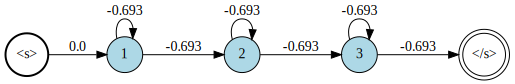

In [5]:
fsm = FSM{Float64}()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(initstate(fsm), s1)
link!(s1, s1)
link!(s1, s2)
link!(s2, s2)
link!(s2, s3)
link!(s3, s3)
link!(s3, finalstate(fsm))

fsm = fsm |> weightnormalize

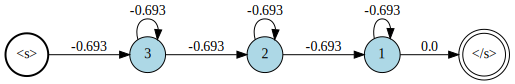

In [6]:
transpose(fsm)

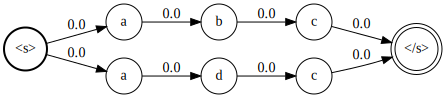

In [7]:
fsm = union(LinearFSM(["a", "b", "c"]), LinearFSM(["a", "d", "c"]))

In [8]:
using StatsFuns: logaddexp

In [14]:
nfsm = FSM{Float64}()

tree = Dict()
stack = [(initstate(fsm), tree)]
while ! isempty(stack)
    state, node = popfirst!(stack)
    
    for l in links(state)
        s = (l.dest.pdfindex, l.dest.label)
        w, nextlvl = get(node, s, (-Inf, Dict()))
        node[s] = (logaddexp(l.weight, w), nextlvl)
        push!(stack, (l.dest, node[s][2]))
    end 
end

tree[(nothing, "a")][2]

Dict{Any,Any} with 2 entries:
  (nothing, "b") => (0.0, Dict{Any,Any}((nothing, "c")=>(0.0, Dict{Any,Any}((no…
  (nothing, "d") => (0.0, Dict{Any,Any}((nothing, "c")=>(0.0, Dict{Any,Any}((no…

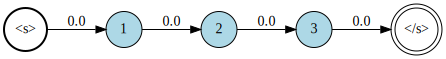

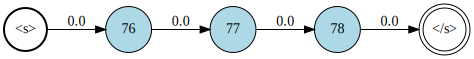

In [13]:
function makehmm(pdfidxs)
    fsm = FSM{Float64}()
    prevstate = initstate(fsm)
    for pdfidx in pdfidxs
        state = addstate!(fsm, pdfindex = pdfidx)
        
        # We don't add the self loop here as it will be
        # removed by the minimization algorithms

        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    fsm |> weightnormalize
end

hmms = Dict()
for (i, l) in enumerate('a':'z')
    startidx = 3 * (i -1) + 1
    hmms["$l"] = makehmm([startidx, startidx + 1, startidx + 2])
end
display(hmms["a"])
display(hmms["z"])

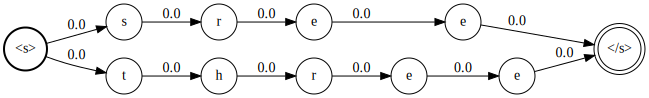

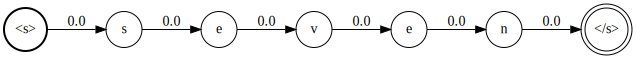

In [38]:
spelling = Dict(
    "zero"  => [("z", "e", "r", "o")],
    "one"   => [("o", "n", "e")],
    "two"   => [("t", "w", "o")],
    "three" => [("t", "h", "r", "e", "e"),
                ("s", "r", "e", "e")],  # French pronunciation 😁
    "four"  => [("f", "o", "u", "r")],
    "five"  => [("f", "i", "v", "e")],
    "six"   => [("s", "i", "x")],
    "seven" => [("s", "e", "v", "e", "n")],
    "eight" => [("e", "i", "g", "h", "t")],
    "nine"  => [("n", "i", "n", "e")]
)

function makepronunciation(pronunciation)
    fsm = FSM{Float64}()
    prevstate = initstate(fsm)
    for letter in pronunciation
        state = addstate!(fsm, label = letter)
        link!(prevstate, state)
        prevstate = state
    end
    link!(prevstate, finalstate(fsm))
    fsm
end

lexicon = Dict()
for (word, pronunciations) in spelling
    lexicon[word] = union(makepronunciation.(pronunciations)...) #|> minimize!
end

display(lexicon["three"])
display(lexicon["seven"])

In [35]:
test = deepcopy(lexicon["three"])
test |> weightnormalize!

LoadError: KeyError: key "three" not found

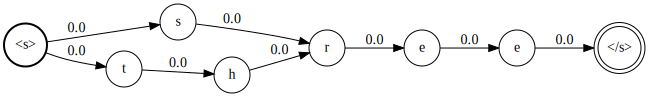

In [5]:
test = deepcopy(lexicon["three"])
determinize!(test)

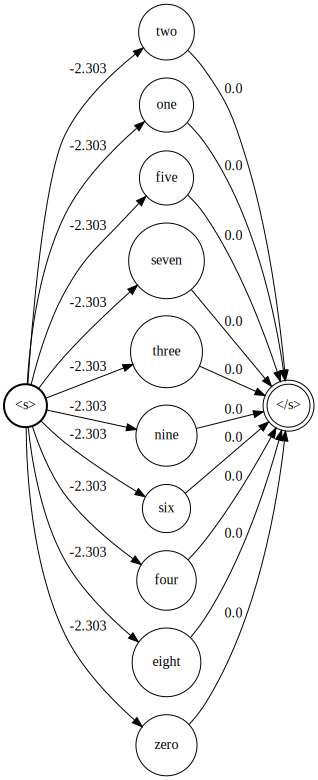

In [6]:
words = keys(lexicon)

# Create a simple unigram language model
lm = FSM()
for word in keys(lexicon)
    s = addstate!(lm, label = word)
    link!(lm, initstate(lm), s)
    link!(lm, s, finalstate(lm))
end

lm = lm |> weightnormalize!

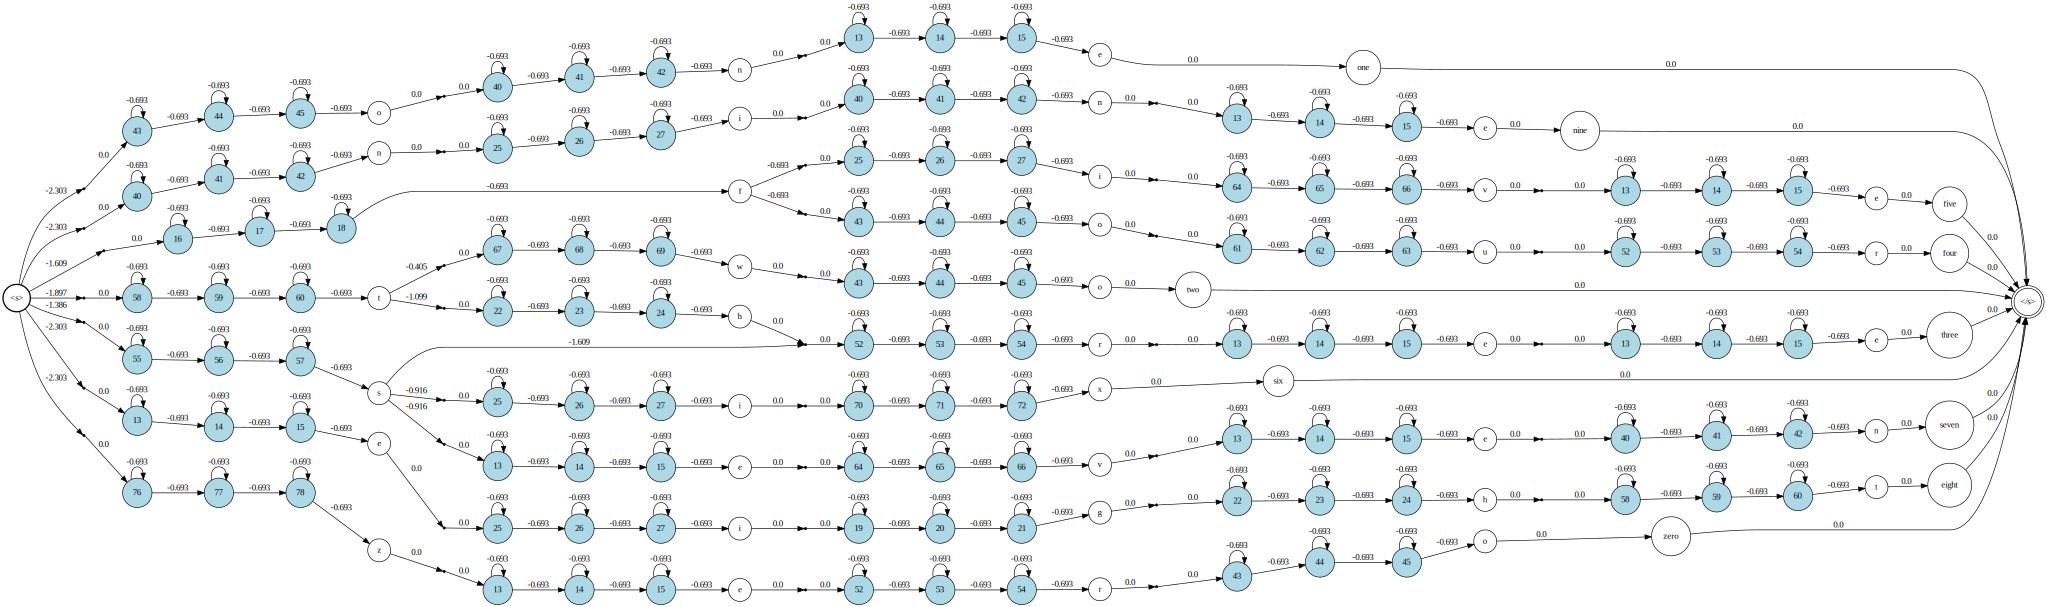

In [7]:
decoder = compose!(compose!(lm, lexicon) |> minimize!, hmms) |> addselfloop!

In [8]:
emissionsmap = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3,
    "d" => 4
)

fsm = FSM()
s1 = addstate!(fsm, pdfindex = 1)
s2 = addstate!(fsm, pdfindex = 2)
s3 = addstate!(fsm, pdfindex = 3)

link!(fsm, initstate(fsm), s1)
link!(fsm, s1, s2)
link!(fsm, s2, s3)
link!(fsm, s3, finalstate(fsm))

1-element Array{Link,1}:
 Link{Float64}(State(finalstateid), State(3, pdfindex = 3), 0.0)

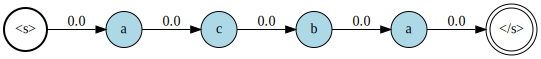

In [9]:
fsm1 = LinearFSM(["a", "c", "b", "a"], emissionsmap)

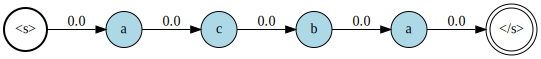

In [10]:
deepcopy(fsm1) |> determinize!

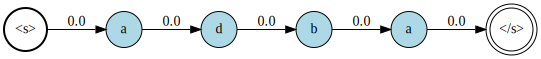

In [11]:
fsm2 = LinearFSM(["a", "d", "b", "a"], emissionsmap)

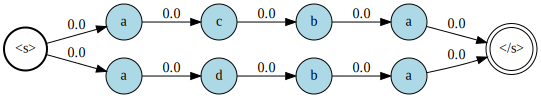

In [12]:
fsm = union(fsm1, fsm2)
fsm

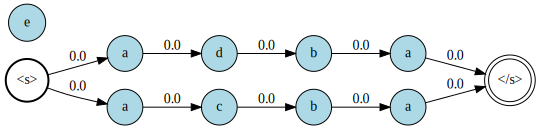

In [13]:
addstate!(fsm, pdfindex = 10, label = " e") # add unreachable state
fsm

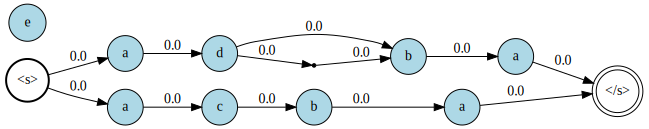

In [14]:
# Add useless connection
tmp = addstate!(fsm)
link!(fsm, fsm.states[6], tmp)
link!(fsm, tmp, fsm.states[7])
fsm

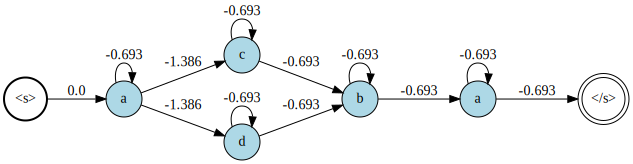

In [15]:
fsm = fsm |> minimize! |> addselfloop!

In [16]:
function pdfresps(lnαβ::Vector{<:Dict}, S::Int64)
    N = length(lnαβ)
    resps = zeros(S, N)
    for n in 1:N
        for (s, w) in lnαβ[n]
            resps[s.pdfindex, n] += exp(w)
        end
    end
    resps
end

function stateresps(lnαβ::Vector{<:Dict}, S::Int64)
    N = length(lnαβ)
    resps = zeros(S, N)
    for n in 1:N
        for (s, w) in lnαβ[n]
            resps[s.id, n] = exp(w)
        end
    end
    resps
end

stateresps (generic function with 1 method)

In [17]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)

4×100 Array{Float64,2}:
 -1.39704    0.953029   0.213667   …  0.272182   0.493395  0.848061
 -0.945629  -0.174832   0.0384761     0.143531   0.660949  0.620075
  0.500679  -0.0566224  1.31223       0.305778  -0.148159  0.985568
  0.166352  -0.195443   0.911029      0.135529   0.881307  0.766296

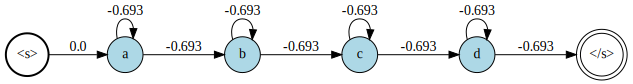

In [18]:
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
fsm1 |> addselfloop!

In [19]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnα = αrecursion(fsm1 |> addselfloop!, 0*llh .+ 10) 
#heatmap(pdfresps(lnαβ, 4))

[n = 1]  	1	1 = 10.000  
[n = 2]  	2	1 = 19.307  	2 = 19.307  
[n = 3]  	2	1 = 28.614  	2 = 29.307  	3 = 28.614  
[n = 4]  	3	1 = 37.921  	2 = 39.019  	3 = 39.019  	4 = 37.921  
[n = 5]  	3	1 = 47.227  	2 = 48.614  	3 = 49.019  	4 = 48.614  
[n = 6]  	3	1 = 56.534  	2 = 58.144  	3 = 58.837  	4 = 58.837  
[n = 7]  	4	1 = 65.841  	2 = 67.633  	3 = 68.549  	4 = 68.837  
[n = 8]  	4	1 = 75.148  	2 = 77.094  	3 = 78.192  	4 = 78.703  
[n = 9]  	4	1 = 84.455  	2 = 86.534  	3 = 87.787  	4 = 88.480  
[n = 10]  	4	1 = 93.762  	2 = 95.959  	3 = 97.345  	4 = 98.192  
[n = 11]  	4	1 = 103.069  	2 = 105.371  	3 = 106.875  	4 = 107.856  
[n = 12]  	4	1 = 112.375  	2 = 114.773  	3 = 116.383  	4 = 117.481  
[n = 13]  	4	1 = 121.682  	2 = 124.167  	3 = 125.872  	4 = 127.076  
[n = 14]  	4	1 = 130.989  	2 = 133.554  	3 = 135.346  	4 = 136.645  
[n = 15]  	4	1 = 140.296  	2 = 142.935  	3 = 144.807  	4 = 146.193  
[n = 16]  	4	1 = 149.603  	2 = 152.311  	3 = 154.257  	4 = 155.723  
[n = 17]  	4	1 = 158.91

┌ Warning: `sort(d::Dict; args...)` is deprecated, use `sort!(OrderedDict(d); args...)` instead.
│   caller = ip:0x0
└ @ Core :-1


In [20]:
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnβ = βrecursion(fsm1 |> addselfloop!, 0*llh .+10) 
#heatmap(pdfresps(lnαβ, 4))

[n = 1]  	1	1 = 933.341  	2 = 929.865  	3 = 925.974  	4 = 921.378  
[n = 2]  	1	1 = 924.004  	2 = 920.538  	3 = 916.657  	4 = 912.072  
[n = 3]  	1	1 = 914.666  	2 = 911.211  	3 = 907.339  	4 = 902.765  
[n = 4]  	1	1 = 905.328  	2 = 901.883  	3 = 898.022  	4 = 893.458  
[n = 5]  	1	1 = 895.989  	2 = 892.555  	3 = 888.705  	4 = 884.151  
[n = 6]  	1	1 = 886.650  	2 = 883.227  	3 = 879.387  	4 = 874.844  
[n = 7]  	1	1 = 877.311  	2 = 873.899  	3 = 870.070  	4 = 865.537  
[n = 8]  	1	1 = 867.971  	2 = 864.570  	3 = 860.752  	4 = 856.230  
[n = 9]  	1	1 = 858.631  	2 = 855.241  	3 = 851.434  	4 = 846.924  
[n = 10]  	1	1 = 849.291  	2 = 845.912  	3 = 842.117  	4 = 837.617  
[n = 11]  	1	1 = 839.950  	2 = 836.583  	3 = 832.799  	4 = 828.310  
[n = 12]  	1	1 = 830.609  	2 = 827.253  	3 = 823.480  	4 = 819.003  
[n = 13]  	1	1 = 821.267  	2 = 817.923  	3 = 814.162  	4 = 809.696  
[n = 14]  	1	1 = 811.925  	2 = 808.593  	3 = 804.844  	4 = 800.389  
[n = 15]  	1	1 = 802.583  	2 = 799.263  	3 

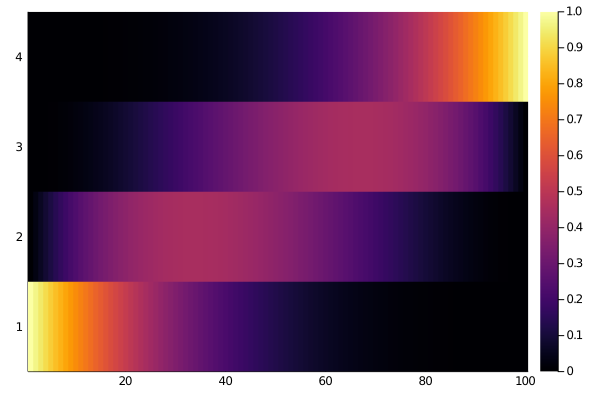

In [21]:
using Plots
D,N = 4, 100 # number of distributions times number of frames
llh = randn(D, N)
fsm1 = LinearFSM(["a", "b", "c", "d"], emissionsmap)
lnαβ, tll = αβrecursion(fsm1 |> addselfloop!, 0 * llh .+ 10) 
heatmap(pdfresps(lnαβ, 4))

In [22]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
pdfresps(lnαβ, length(emissionsmap))


4×100 Array{Float64,2}:
 1.0  0.960112    0.952813     0.944341     …  0.788687     0.812915  1.0
 0.0  0.0         3.60924e-10  6.32014e-10     0.210265     0.187085  0.0
 0.0  1.72842e-7  2.37748e-7   7.36086e-7      5.94366e-11  0.0       0.0
 0.0  0.0398878   0.0471865    0.0556585       0.00104793   0.0       0.0

In [ ]:
viterbi(fsm, llh)

┌ Warning: viterbi is depracated! Use bestpath instead.
└ @ MarkovModels /home/lucas/GithubRepositories/MarkovModels/src/inference.jl:232


In [24]:
using Plots

In [25]:
llh = zeros(4,5)

4×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

In [45]:
llh[:,1:2] .= [1, 0.5, 0, 0]
llh[:,3:4] .= [0.5, 1, 0.5, 0]
llh[:,5:5] .= [0, 0.5, 1, 0.5]
llh

4×5 Array{Float64,2}:
 1.0  1.0  0.5  0.5  0.0
 0.5  0.5  1.0  1.0  0.5
 0.0  0.0  0.5  0.5  1.0
 0.0  0.0  0.0  0.0  0.5

In [27]:
α = αrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 

[n = 1]  	23	23 = 1.000  
[n = 2]  	23	20 = -0.386  	21 = -0.386  	23 = 1.307  
[n = 3]  	23	19 = 0.614  	20 = 0.734  	21 = 0.234  	23 = 1.114  
[n = 4]  	19	18 = 0.421  	19 = 1.954  	20 = 1.089  	21 = 0.332  	23 = 0.921  
[n = 5]  	19	18 = 1.456  	19 = 2.243  	20 = 1.749  	21 = 0.781  	23 = 0.227  


In [28]:
β = βrecursion(fsm, llh; pruning = nopruning) # the lower the more pruning 
β

[n = 1]  	20	18 = -0.773  	19 = 0.676  	20 = 0.926  	21 = 0.882  	23 = 0.456  
[n = 2]  	20	18 = -1.079  	19 = 0.601  	20 = 0.715  	21 = 0.601  	23 = -0.799  
[n = 3]  	19	18 = -0.886  	19 = 0.088  	20 = -0.386  	21 = -0.386  
[n = 4]  	18	18 = -0.693  	19 = -0.693  
[n = 5]  	18	18 = 0.000  


In [29]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	23	23 = 0.000  
[n = 2]  	23	20 = -1.128  	21 = -1.242  	23 = -0.948  
[n = 3]  	19	19 = -0.755  	20 = -1.109  	21 = -1.609  
[n = 4]  	19	18 = -1.729  	19 = -0.195  
[n = 5]  	18	18 = 0.000  


In [30]:
lnαβ, tll = αβrecursion(fsm, llh) # the lower the more pruning 
lnαβ

[n = 1]  	23	23 = 0.000  
[n = 2]  	23	20 = -1.128  	21 = -1.242  	23 = -0.948  
[n = 3]  	19	19 = -0.755  	20 = -1.109  	21 = -1.609  
[n = 4]  	19	18 = -1.729  	19 = -0.195  
[n = 5]  	18	18 = 0.000  


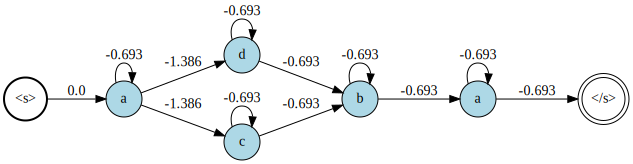

In [32]:
fsm

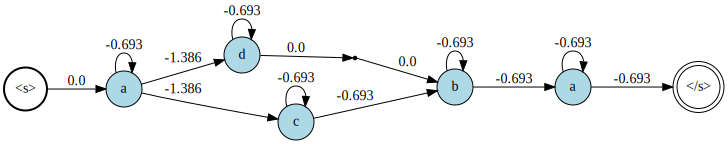

In [44]:
g = deepcopy(fsm)
unlink!(g, g.states[21], g.states[19])
s = addstate!(g)
link!(g, g.states[21], s)
link!(g, s, g.states[19])
g

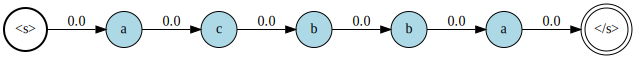

In [57]:
D,N = 4, 5 # number of distributions times number of frames
llh = randn(D, N)
path = viterbi(fsm, llh) 